<a href="https://colab.research.google.com/github/Sam-Gartenstein/llm-and-deep-learning-projects/blob/main/Emotion_Dataset_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Dataset Fine-Tuning

In this notebook, I fine-tune a transformer-based model to classify text into one of six emotion categories using the Emotion dataset. The aim is to move beyond zero-shot inference and develop a model that is explicitly adapted to the structure and nuances of the dataset. By fine-tuning a pre-trained DistilBERT model on labeled examples, the classifier learns task-specific patterns that enable it to make more accurate and reliable predictions. The following sections outline the full training pipeline, including data preparation, tokenization, model initialization, and evaluation.


In [1]:
# -----------------------------------------------------
# Install PyTorch
# -----------------------------------------------------
# This installs the GPU-enabled PyTorch build for CUDA 12.1 (default in Colab).
# If you are running in a CPU-only environment, comment out this line and
# use the CPU installation command shown below instead.

%pip install -q -U torch torchvision torchaudio \
  --index-url https://download.pytorch.org/whl/cu121

# CPU-only alternative:
# %pip install -q -U torch torchvision torchaudio \
#   --index-url https://download.pytorch.org/whl/cpu

In [2]:
# -----------------------------------------------------
# Install Hugging Face and LoRA Ecosystem Packages
# -----------------------------------------------------
# This includes:
# - transformers: model loading, training, and inference
# - tokenizers: efficient tokenization for NLP models
# - datasets: standardized dataset loading and processing
# - evaluate: metrics for model evaluation
# - peft: parameter-efficient fine-tuning methods (e.g., LoRA)
# - loralib: lightweight implementation of LoRA layers

%pip install -q -U \
  "transformers>=4.44" \
  "tokenizers>=0.19.1" \
  "datasets>=2.20" \
  "evaluate>=0.4.1" \
  "peft>=0.12.0" \
  "loralib>=0.1.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.7 MB/s eta 0:00:00


In [3]:
# Import the importlib module to dynamically import other modules by name
import importlib

# List of module names we want to check for availability and version
mods = ["torch", "transformers", "tokenizers", "datasets", "evaluate", "peft", "loralib"]

# Loop through each module name in the list
for m in mods:
    try:
        mod = importlib.import_module(m)
        ver = getattr(mod, "__version__", "<no __version__ attr>")
        print(f"{m}: {ver}")
    except Exception as e:
        print(f"{m}: NOT IMPORTABLE -> {e}")

torch: 2.9.0+cu126
transformers: 4.57.3
tokenizers: 0.22.1
datasets: 4.4.1
evaluate: 0.4.6
peft: 0.18.0
loralib: <no __version__ attr>


In [4]:
# Standard library imports
from collections import Counter

# Third-party imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# UPDATE COMMENTS AND ORGNIAZATION!
from math import ceil
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score


import torch
import evaluate
from datasets import load_dataset, DatasetDict

# Hugging Face Transformers
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    pipeline,
    set_seed,
    TrainingArguments,
    Trainer,
)

# Version / environment info
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
print("evaluate:", evaluate.__version__)

# Reproducibility (sets python, numpy, torch, etc.)
set_seed(42)

# (Optional but nice to be explicit with torch)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch: 2.9.0+cu126 | cuda: True
evaluate: 0.4.6


## 1. Loading the Dataset

In this section, I load the **[Emotion](https://huggingface.co/datasets/dair-ai/emotion)** dataset from Hugging Face Datasets. This corpus consists of short text passages annotated with one of six emotion labels. After loading the dataset, I examine:

- One example from each split to understand the data structure and annotation format  
- The number of samples in each split to understand dataset size and distribution

In [5]:
# Load the Emotion dataset
dataset = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
# Inspect the first sample from each dataset split to quickly preview the structure and contents
print(dataset["train"][0])
print(dataset["validation"][0])
print(dataset["test"][0])

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon', 'label': 0}
{'text': 'im feeling rather rotten so im not very ambitious right now', 'label': 0}


In [7]:
'''
Print the dataset summary to see the available splits (train, validation, test)
and the number of samples contained in each
'''
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


## 2. Examining Data

### 2.1 Distribution of Classes

Below, I will plot the distribution of classes (emotions) in the training, validation, and test sets.

In [8]:
def plot_label_distribution(dataset_split, label_names, title="Label Distribution"):
    """
    Plots a bar chart of label counts and percentages for a Hugging Face dataset split.

    Args:
        dataset_split: A split of a Hugging Face Dataset (e.g., dataset["train"])
        label_names: A list of label names in order of their corresponding IDs
        title: Title of the plot (e.g., "Training Set Label Distribution")
    """
    # Count label IDs
    label_ids = dataset_split["label"]
    label_counts = Counter(label_ids)

    # Compute counts and percentages
    counts = [label_counts[i] for i in range(len(label_names))]
    total = sum(counts)
    percentages = [count / total * 100 for count in counts]

    # Plot
    sns.set(style="darkgrid")
    plt.figure(figsize=(8, 5))
    barplot = sns.barplot(x=label_names, y=counts, palette="husl")
    plt.ylim(0, max(counts) * 1.15)

    # Annotate bars
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        label = f"{count} ({pct:.1f}%)"
        plt.text(i, count * 1.01, label, ha='center', va='bottom', fontsize=10)

    # Final touches
    plt.title(title, fontsize=14)
    plt.ylabel("Number of Samples")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
# Define the label names for the Emotion dataset
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

/tmp/ipython-input-1348541058.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_names, y=counts, palette="husl")


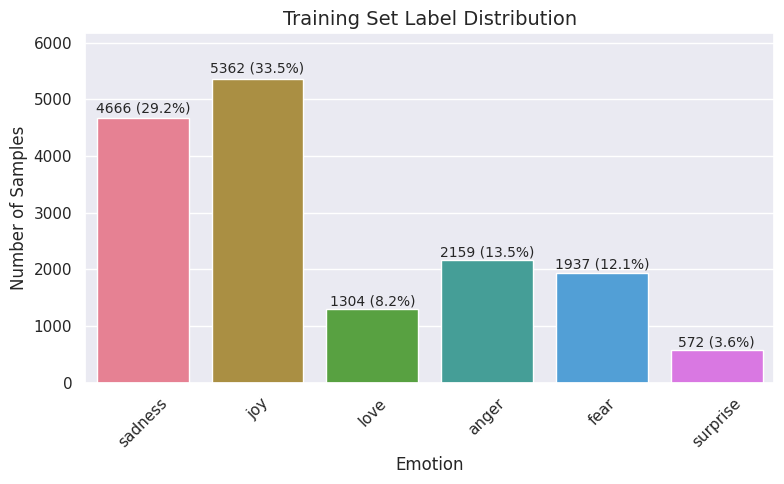

In [10]:
# Plot emotion distribution from the training set
plot_label_distribution(dataset["train"], labels, title="Training Set Label Distribution");

/tmp/ipython-input-1348541058.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_names, y=counts, palette="husl")


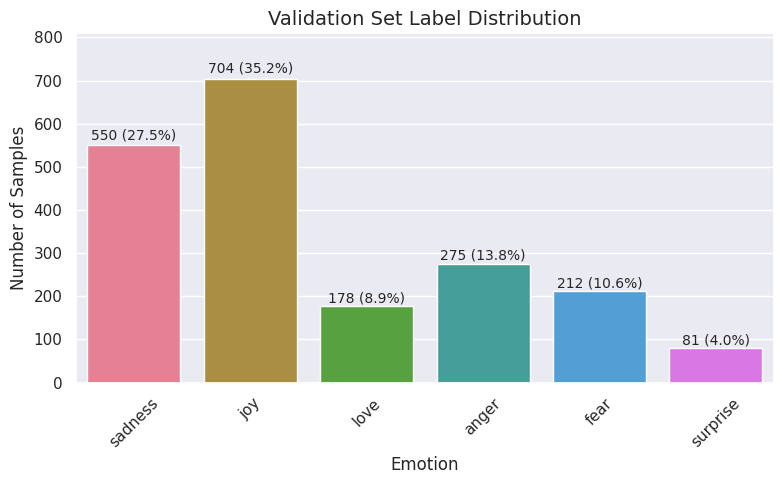

In [11]:
# Plot emotion distribution from the validation set
plot_label_distribution(dataset["validation"], labels, title="Validation Set Label Distribution");

/tmp/ipython-input-1348541058.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_names, y=counts, palette="husl")


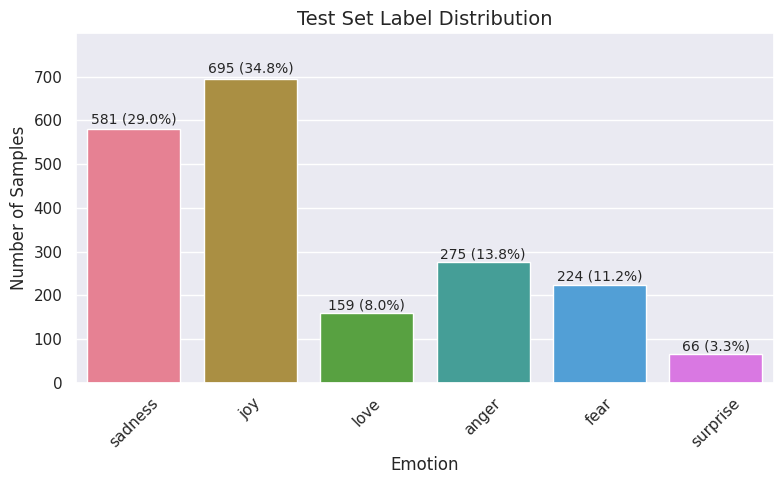

In [12]:
# Plot emotion distribution from the test set
plot_label_distribution(dataset["test"], labels, title="Test Set Label Distribution");

#### Class Anaylsis

In all three datasets, there is an uneven distribution of the classes, and their proportions are nearly identical. The highest represented emotions are joy and sadness and the lowest is surprise.

### 2.2 Text Length Analysis

To better understand the structure of the data, we calculate the distribution of text lengths in the training set. Each text entry is tokenized by whitespace, and summary statistics (mean, median, minimum, and maximum length in words) are reported.

Analyzing text length helps determine appropriate preprocessing parameters, such as the tokenizer's `max_length` value, and ensures that the model can handle the majority of samples without excessive truncation or padding.


In [13]:
# Get list of texts from the dataset
train_texts = dataset["train"]["text"]

# Compute lengths in words
lengths = np.array([len(text.split()) for text in train_texts])

# Summary statistics
mean_length = lengths.mean()
median_length = np.median(lengths)
max_length = lengths.max()
min_length = lengths.min()

# Display results
print(f"Mean length: {mean_length:.2f} words")
print(f"Median length: {median_length:.0f} words")
print(f"Max length: {max_length} words")
print(f"Min length: {min_length} words")

Mean length: 19.17 words
Median length: 17 words
Max length: 66 words
Min length: 2 words


### 2.3 Example Inspection by Emotion

To better understand how the dataset represents each emotion category, we examine one example text for every label in the training set. This helps verify that the samples align with their intended emotion and provides a quick qualitative sense of tone, phrasing, and content across classes.

In [14]:
# One example per label (simple + safe)
for i, name in enumerate(labels):
    try:
        ex = next(e for e in dataset["train"] if e["label"] == i)
        print(f"{name.upper()}: {ex['text']}")
    except StopIteration:
        print(f"{name.upper()}: (no example found)")

SADNESS: i didnt feel humiliated
JOY: i have been with petronas for years i feel that petronas has performed well and made a huge profit
LOVE: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
ANGER: im grabbing a minute to post i feel greedy wrong
FEAR: i feel as confused about life as a teenager or as jaded as a year old man
SURPRISE: ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny


## 3. Zero Shot Inference



### 3.1 Initialization

I initialize a Hugging Face [pipeline](https://huggingface.co/docs/transformers/en/main_classes/pipelines) for **zero-shot text classification** using the `facebook/bart-large-mnli` model. This model is pre-trained for **natural language inference (NLI)** and is commonly used for zero-shot tasks.

The pipeline is configured to run on a **GPU** when available and otherwise falls back to the **CPU**, ensuring that subsequent zero-shot evaluations use the appropriate computation device.

In [15]:
# Initialize a zero-shot classification pipeline
zs = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


### 3.2 Zero-Shot Evaluation Function

To systematically assess zero-shot performance, I define a helper function `zero_shot_eval` that applies the zero-shot classification pipeline to an entire dataset split and computes summary metrics.

The function:

- Takes a dataset split (e.g., `dataset["validation"]`), a list of **label names**, and a Hugging Face zero-shot **classifier pipeline**.
- Runs inference in **mini-batches** to avoid memory issues and optionally displays a progress bar.
- Supports both the default and a custom **hypothesis template** for the candidate labels.
- Converts the model’s predicted labels into integer indices and compares them with the reference labels.
- Computes one or more evaluation metrics (e.g., **accuracy**, **F1-score**), using macro-averaging for multi-class classification when appropriate.

The function returns a dictionary containing the computed metrics and the array of predicted label indices, providing a reusable interface for comparing different zero-shot configurations.

In [16]:
def _ensure_metric_obj(m):
    """Accept metric name ('accuracy') or evaluate.Metric object."""
    return evaluate.load(m) if isinstance(m, str) else m

def zero_shot_eval(
    dataset_split,
    labels,
    classifier,
    metrics=("accuracy", "f1"),
    average="macro",
    batch_size=16,
    hypothesis_template=None,
    truncation=True,
    show_progress=True,
    desc="Zero-shot inference"
):
    texts = list(dataset_split["text"])
    refs  = np.array(dataset_split["label"])
    n = len(texts)

    base_kwargs = dict(candidate_labels=labels, truncation=truncation)
    if hypothesis_template is not None:
        base_kwargs["hypothesis_template"] = hypothesis_template

    outputs = []
    iterator = range(0, n, batch_size)
    if show_progress:
        iterator = tqdm(iterator, total=ceil(n / batch_size), desc=desc, leave=False)

    for start in iterator:
        batch = texts[start:start + batch_size]
        out = classifier(batch, **base_kwargs)
        if isinstance(out, dict):
            out = [out]
        outputs.extend(out)

    preds = np.array([labels.index(o["labels"][0]) for o in outputs])

    def _ensure_metric_obj(m):
        return evaluate.load(m) if isinstance(m, str) else m

    results = {}
    for m in metrics:
        metric = _ensure_metric_obj(m)
        mname  = metric.name
        kwargs = {"average": average} if mname in {"f1", "precision", "recall"} else {}
        val = metric.compute(predictions=preds, references=refs, **kwargs)
        results[mname] = next(iter(val.values())) if isinstance(val, dict) and len(val) == 1 else val

    results["predictions"] = preds
    return results

### 3.3 Zero-Shot Evaluation

To assess baseline model performance, I evaluate the zero-shot classifier on the validation set using two different hypothesis templates:

1. **Default template:** Uses the Hugging Face pipeline’s built-in hypothesis formulation, providing an out-of-the-box baseline.
2. **Custom emotion template:** Uses the task-specific phrasing `"This text expresses {}."`, which may better align the model with emotion classification.

For both evaluations, I compute macro-averaged **accuracy** and **F1-score**. Comparing the two helps determine whether task-aligned phrasing improves zero-shot performance.

In [17]:
res_default = zero_shot_eval(
    dataset["validation"], labels, zs,
    average="macro",
    hypothesis_template=None,     # pipeline’s built-in default template
    batch_size=16,
    show_progress=True,
    desc="ZS (default template)"
)

print("No template:", {k: v for k, v in res_default.items() if k != "predictions"})

ZS (default template):   0%|          | 0/125 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


No template: {'accuracy': 0.3945, 'f1': 0.412311095763294}


In [18]:
res_tpl = zero_shot_eval(
    dataset["validation"], labels, zs,
    metrics=("accuracy","f1"), average="macro",
    hypothesis_template="This text expresses {}.",
    batch_size=16, show_progress=True, desc="ZS (expresses {})"
)

print("Expresses {}:", {k: v for k, v in res_tpl.items() if k != "predictions"})

ZS (expresses {}):   0%|          | 0/125 [00:00<?, ?it/s]

Expresses {}: {'accuracy': 0.4795, 'f1': 0.4483312095812349}


####  Zero-Shot Analysis

Evaluating the zero-shot classifier with the pipeline’s **default hypothesis template** gives an accuracy of **39.45%** and a macro-F1 of **41.23%**. These values provide a baseline for how well the pre-trained NLI model distinguishes emotions without any task-specific adaptations.

When the hypothesis is rewritten using the custom template **“This text expresses {}.”**, performance improves across metrics. Accuracy rises to **47.95%**, and the macro-F1 increases to **44.83%**. Although the gain is moderate, it is consistent, suggesting that the model benefits from having the emotion labels placed in a phrasing that is more directly aligned with the classification task.

Overall, the results show that zero-shot performance is sensitive to how label descriptions are expressed. A task-relevant hypothesis structure helps the model better understand what each label represents. At the same time, the relatively low absolute values highlight that zero-shot inference has inherent limitations on this dataset, reinforcing the importance of fine-tuning for stronger predictive performance.



## 4. Fine Tuning

### 4.1 Initializing Label Mappings and Pretrained Model

To prepare the model for fine-tuning, I first construct bidirectional mappings
between the emotion label names and their corresponding integer class indices.
These mappings (`id2label` and `label2id`) ensure that the classifier’s outputs
are aligned with the dataset’s label scheme and allow predictions to be
interpreted using the original category names.

With the label mappings defined, I load the **DistilBERT** checkpoint
(`distilbert-base-uncased`) from the Hugging Face Hub and initialize both the
tokenizer and the sequence classification model. The model is configured with a
classification head sized to the number of emotion categories and incorporates
the label mappings so that the output logits correspond directly to the emotion
labels. This setup establishes the foundation for subsequent fine-tuning on the
emotion dataset.


In [19]:
# Create a mapping from integer class indices to label names
id2label = {i: n for i, n in enumerate(labels)}

# Create the reverse mapping from label names to integer class indices
label2id = {n: i for i, n in enumerate(labels)}

# Print both dictionaries to verify the mappings
print(id2label)
print(label2id)

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


In [20]:
# Define the model checkpoint from Hugging Face Hub
model_name = "distilbert-base-uncased"

# Load tokenizer and model with classification head
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Tokenization

To prepare the text for model training, each sentence is converted into numerical token IDs using the **DistilBERT tokenizer**. The tokenization function applies padding and truncation to a fixed maximum length of 128 tokens, ensuring that all inputs have consistent dimensions. The function is applied to each dataset split (`train`, `validation`, and `test`) using the `map` method with batching enabled, producing a `DatasetDict` of tokenized datasets.

A `DataCollatorWithPadding` is also initialized to handle dynamic padding at batch time, allowing efficient training while maintaining input uniformity.



In [21]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [22]:
'''
Apply the tokenization function to each split (batched for efficiency)
and store the results in a new DatasetDict for training, validation, and testing.
'''

tokenized_datasets = DatasetDict({
    "train": dataset["train"].map(tokenize_function, batched=True),
    "validation": dataset["validation"].map(tokenize_function, batched=True),
    "test": dataset["test"].map(tokenize_function, batched=True),
})


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
# Dynamically pad sequences within each batch
data_collator = DataCollatorWithPadding(tokenizer)

### 4.3 Evaluation

To assess model performance during validation, I define a `compute_metrics` function that computes two standard metrics for multi-class classification: **accuracy** and **macro-averaged F1-score**. The function receives the model’s logits and true labels, converts the logits into predicted class indices using
`argmax`, and then returns the metric values in a dictionary. This function is passed to the Hugging Face `Trainer` so that metrics are automatically computed at the end of each evaluation step.


In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
    }

### 4.4 Training Setup

I configure the Hugging Face `TrainingArguments` to control the fine-tuning process. The model is trained for **3 epochs** with a learning rate of **2e-5**, a batch size of **16** for both training and evaluation, and **weight decay** for regularization. Evaluation and checkpoint saving are performed at the end of each epoch, and `load_best_model_at_end=True` ensures that the checkpoint with the highest **F1-score** on the validation set is restored. A fixed random seed is also set for reproducibility.

Using these arguments, I instantiate a `Trainer` that bundles together the model, tokenized training and validation datasets, tokenizer, data collator, and the `compute_metrics` function. This object manages the full training and evaluation loop, including logging, checkpointing, and metric computation.


In [25]:
# Set hyperparameters and training behavior for fine-tuning DistilBERT
training_args = TrainingArguments(
    output_dir="./emotion_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    seed=42,
)

In [26]:
# Initialize the Trainer with the model, datasets, tokenizer, collator, and evaluation metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2888649507.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 4.5 Model Training and Evaluation

I fine-tune the DistilBERT classifier using the configured `Trainer`, which handles the full training loop, logging, and checkpointing. After training is complete, I evaluate the best-performing model on the held-out test set to assess its generalization performance.


In [27]:
# Run the fine-tuning process
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sg4283 (sg4283-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.249300,0.196385,0.931000,0.906968
2,0.148700,0.164247,0.934500,0.907952
3,0.099000,0.160912,0.933500,0.907888


TrainOutput(global_step=3000, training_loss=0.25086822255452473, metrics={'train_runtime': 584.8656, 'train_samples_per_second': 82.07, 'train_steps_per_second': 5.129, 'total_flos': 1589722177536000.0, 'train_loss': 0.25086822255452473, 'epoch': 3.0})

In [28]:
# Evaluate the trained model on the test split
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.17016179859638214,
 'eval_accuracy': 0.9295,
 'eval_f1': 0.8822287884017262,
 'eval_runtime': 7.0531,
 'eval_samples_per_second': 283.565,
 'eval_steps_per_second': 17.723,
 'epoch': 3.0}

#### Fine-Tuned Model Evaluation

Evaluating the fine-tuned DistilBERT classifier on the validation split shows a substantial improvement over the zero-shot baseline. The model achieves an **accuracy of 92.95%** and a **macro-F1 score of 88.22%**, far higher than the zero-shot results, which were below 50%. This demonstrates that fine-tuning on supervised emotion data allows the model to more reliably distinguish between the six emotion categories.

The evaluation loss (**0.1702**) is low, indicating that the model fits the task well without evident overfitting. The runtime metrics further show that the evaluation process is efficient. Overall, these results illustrate that fine-tuning dramatically improves performance compared with zero-shot inference, highlighting the importance of task-specific training for emotion classification.


###

## 5. Testing the Fine-Tuned Model

To examine how the fine-tuned classifier behaves on new inputs, I create a Hugging Face `pipeline` for text classification using the trained model and tokenizer. I then apply the pipeline to several short example sentences to inspect the predicted emotion distributions. This provides a quick qualitative check on whether the model captures the emotional tone of previously unseen text.


In [29]:
# Create a text-classification pipeline using the fine-tuned model and tokenizer
emotion_classifier = pipeline(
    task="text-classification",
    model=trainer.model,
    tokenizer=trainer.tokenizer,
    return_all_scores=True,
    device=0
)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


###

### 5.1 Sad Statement

In this test, I provide the model with a clearly negative and emotionally
distressed sentence to verify that it assigns high probability to the
sadness-related label.

In [30]:
emotion_classifier("I can't stop crying and everything feels meaningless.")

[[{'label': 'sadness', 'score': 0.9981391429901123},
  {'label': 'joy', 'score': 0.0008854317711666226},
  {'label': 'love', 'score': 0.0001799881283659488},
  {'label': 'anger', 'score': 0.00040534112486056983},
  {'label': 'fear', 'score': 0.0002845209965016693},
  {'label': 'surprise', 'score': 0.00010557289351709187}]]

#### Sad Statement Analysis

The model assigns a nearly 100% probability to **sadness**, indicating that it correctly interprets the sentence as expressing strong negative affect. It also avoids misclassifying the text as fear or anger, showing confident and appropriate behavior on this example.

### 5.2 Joyful Statement

In this example, I provide a clearly positive and enthusiastic sentence to
verify that the model assigns the highest probability to the **joy** label.


In [31]:
emotion_classifier("This is the best day of my life!")

[[{'label': 'sadness', 'score': 0.0032406316604465246},
  {'label': 'joy', 'score': 0.990267813205719},
  {'label': 'love', 'score': 0.002107821637764573},
  {'label': 'anger', 'score': 0.0028374376706779003},
  {'label': 'fear', 'score': 0.0008823391399346292},
  {'label': 'surprise', 'score': 0.0006640336359851062}]]

#### Joyful Statement Analysis


As with the sadness example, the model assigns a nearly 100% probability to **joy**, correctly interpreting the strong positive sentiment expressed in the sentence. It also avoids misclassifying the text into related categories, demonstrating confident and appropriate behavior on this example.

### 5.3 Love Example

In this example, I use a sentence expressing affection and commitment to see whether the model associates it with the **love** label. This helps evaluate how well the classifier captures emotionally positive but non-joy expressions, such as affection, intimacy, or romantic intent.


In [32]:
emotion_classifier("Will you marry me?")

[[{'label': 'sadness', 'score': 0.13806892931461334},
  {'label': 'joy', 'score': 0.6280600428581238},
  {'label': 'love', 'score': 0.03508926182985306},
  {'label': 'anger', 'score': 0.13740846514701843},
  {'label': 'fear', 'score': 0.048491910099983215},
  {'label': 'surprise', 'score': 0.012881403788924217}]]

#### Proposal Statement Analysis

The model assigns the highest probability to **joy** rather than **love**, suggesting that it interprets the proposal as a generally positive and enthusiastic moment rather than an expression of romantic affection. Several other emotions receive small but non-negligible scores, indicating some uncertainty. Overall, the model captures the positive tone of the sentence but does not strongly associate it with the love category.


### 5.4 Mixed Emotional Statement I

This sentence expresses both sadness and anger, making it a useful test of the model’s ability to handle emotionally complex or ambiguous inputs. The goal is to see whether the classifier captures the presence of multiple negative emotions and how it distributes its confidence across them.


In [33]:
emotion_classifier("I am so sad it makes me angry!")

[[{'label': 'sadness', 'score': 0.0013346188934519887},
  {'label': 'joy', 'score': 0.0006342190317809582},
  {'label': 'love', 'score': 0.00023834995226934552},
  {'label': 'anger', 'score': 0.996613085269928},
  {'label': 'fear', 'score': 0.0009437924600206316},
  {'label': 'surprise', 'score': 0.0002359555655857548}]]

#### Mixed Emotional Statement I Analysis

Although the sentence expresses both sadness and anger, the model assigns an overwhelming probability to **anger** ($\approx$ 99.7%). This suggests that the classifier focuses primarily on the explicit expression of anger rather than the underlying sadness. While the model correctly identifies the dominant emotion, it appears less sensitive to the presence of multiple competing emotional cues.

### 5.5 Mixed Emotional Statement II

This sentence also expresses both sadness and anger. However, by reversing the order of the emotions, it provides a way to see whether the model is sensitive to changes in emphasis or whether it consistently focuses on whichever emotion it perceives as dominant in the text.


In [34]:
emotion_classifier("I am so angry it makes me sad!")

[[{'label': 'sadness', 'score': 0.003276234259828925},
  {'label': 'joy', 'score': 0.0008722904021851718},
  {'label': 'love', 'score': 0.00026168260956183076},
  {'label': 'anger', 'score': 0.9940598011016846},
  {'label': 'fear', 'score': 0.0013036464806646109},
  {'label': 'surprise', 'score': 0.00022632537002209574}]]

#### Mixed Emotional Statement II Analysis

Although this sentence explicitly mentions both anger and sadness, the model again assigns an overwhelming probability to **anger** ($\approx$ 99.4%). This indicates that the classifier heavily prioritizes the dominant or more strongly worded emotion cue and largely ignores the reference to sadness. As in the earlier example, the model shows limited ability to represent multiple emotions at once and tends to collapse mixed expressions into a single dominant category.

### 5.6 Rivalry Night Excitement Statement

This example expresses enthusiasm and joy about an NHL rivalry night, using the phrase “love to hate” in a playful, sports-related context. The goal is to evaluate whether the model can identify the dominant emotional tone, excitement and high energy, despite the presence of emotionally charged phrasing that is not meant to be interpreted literally.

In [35]:
emotion_classifier("Yes! It is NHL rivarly night: the night I love to hate!")

[[{'label': 'sadness', 'score': 0.018984248861670494},
  {'label': 'joy', 'score': 0.02439425140619278},
  {'label': 'love', 'score': 0.004506409168243408},
  {'label': 'anger', 'score': 0.9462835788726807},
  {'label': 'fear', 'score': 0.004977792501449585},
  {'label': 'surprise', 'score': 0.000853685662150383}]]

#### Playoff Excitement Statement Analysis

The model assigns the highest probability to **anger**, with a probability of about 95%. This is likely due to the phrase “love to hate,” which contains explicit negative emotion words even though they are used playfully and the overall statement expresses excitement. While the model correctly picks up on the emotionally charged phrasing, it does not fully capture the sports-related enthusiasm of the statement. This highlights a limitation in distinguishing literal emotional expressions from context-dependent or idiomatic usage.

### 5.7 Gibberish Input

To test how the model handles text with no meaningful linguistic content, I input a string of random characters. This helps evaluate whether the classifier produces low-confidence, evenly distributed predictions in the absence of interpretable emotional cues, or whether it defaults to a particular label.

In [36]:
emotion_classifier("hdfadhfdshfiuadshfiadshfdasufh")

[[{'label': 'sadness', 'score': 0.19185039401054382},
  {'label': 'joy', 'score': 0.3528202474117279},
  {'label': 'love', 'score': 0.028258008882403374},
  {'label': 'anger', 'score': 0.28508350253105164},
  {'label': 'fear', 'score': 0.13221563398838043},
  {'label': 'surprise', 'score': 0.00977224763482809}]]

#### Gibberish Input Analysis

Because the input contains no meaningful language, the model distributes its probabilities across several labels instead of strongly favoring one category. Although **joy** receives the highest score, the differences between labels are relatively small, indicating uncertainty. This suggests that the model struggles to form a strong emotional judgment when the text lacks semantic content.